# Gather and format TC observations

In [5]:
import sys
sys.path.append('../../..')  # Package root directory

import logging
import climada
import warnings
import pandas as pd
import numpy as np
from copy import deepcopy
from pathlib import Path
import copy
import pycountry
import matplotlib.pyplot as plt
from climada.entity.impact_funcs import ImpfSetTropCyclone
from climada.util import log_level
from climada.util.api_client import Client
from climada.util.constants import SYSTEM_DIR


logging.getLogger("climada").setLevel("WARNING")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
countries_to_filter_to = []  # Leave empty to use all
output_dir = Path('/Users/chrisfairless/Projects/CelsiusPro/nccs-supply-chain/resources/observations/data')
emdat = pd.read_csv(Path(output_dir, 'raw', 'public_emdat_custom_request_2024-03-25_2f081933-bed3-41c7-9825-91371555fd41.csv'))
disaster_subtypes = ['Tropical cyclone']
emdat_subset = emdat[
    (emdat['Disaster Subtype'].isin(disaster_subtypes)) &
    (emdat["Total Damage ('000 US$)"] > 0)
]

# fix missing damage obs
emdat_subset.loc[emdat_subset['Start Year'] == 2023, "Total Damage, Adjusted ('000 US$)"] = emdat_subset["Total Damage ('000 US$)"]

assert(min(emdat_subset["Total Damage, Adjusted ('000 US$)"]) > 0)

if len(countries_to_filter_to) > 0:
    emdat_subset = emdat_subset.iloc[[i for i, c in enumerate(emdat_subset['Country']) if c in countries_to_filter_to]]
else:
    countries_to_filter_to = np.unique(emdat_subset[["Country"]])

emdat_subset

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",Total Damage ('000 US$),"Total Damage, Adjusted ('000 US$)",CPI,Admin Units,Entry Date,Last Update
0,1900-0003-USA,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,USA,...,NaN,NaN,NaN,NaN,30000.0,1055280.0,2.842847,NaN,2004-10-18,2023-10-17
14,1906-0015-HKG,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,HKG,...,NaN,NaN,NaN,NaN,20000.0,651407.0,3.070275,NaN,2005-05-02,2023-09-25
37,1911-0006-TWN,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,TWN,...,NaN,NaN,NaN,NaN,20000.0,628143.0,3.183989,NaN,2003-07-01,2023-09-25
40,1912-0008-JPN,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,JPN,...,NaN,NaN,NaN,NaN,20000.0,606483.0,3.297703,NaN,2003-07-01,2023-09-25
41,1912-0010-PHL,Yes,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,PHL,...,NaN,NaN,NaN,NaN,10000.0,303241.0,3.297703,NaN,2003-07-01,2023-09-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11830,2023-0603-BRA,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,NaN,BRA,...,NaN,NaN,NaN,NaN,705000.0,705000.0,NaN,NaN,2023-09-11,2024-01-29
11852,2023-0675-MEX,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,GLIDE:TC-2023-000209,Tropical storm 'Otis',MEX,...,NaN,NaN,4000000.0,NaN,12000000.0,12000000.0,NaN,NaN,2023-10-30,2024-03-04
11857,2023-0686-BGD,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical cyclone 'Hamoon',BGD,...,NaN,NaN,NaN,NaN,250000.0,250000.0,NaN,NaN,2023-10-31,2024-02-12
11896,2023-0792-IND,No,nat-met-sto-tro,Natural,Meteorological,Storm,Tropical cyclone,NaN,Tropical storm 'Michaung',IND,...,NaN,NaN,NaN,NaN,125000.0,125000.0,NaN,NaN,2023-12-06,2024-02-12


In [3]:
# add the vulnerability region code that we and CLIMADA use to group our calibrations

_, _, _, region_dict = ImpfSetTropCyclone.get_countries_per_region(region='all')

def lookup_region(iso3a):
    for region, country_list in region_dict.items():
        if iso3a in country_list:
            return region
    print(f'Could not find a region for country {iso3a}')
    return None

emdat_subset['region'] = [lookup_region(iso3a) for iso3a in emdat_subset['ISO']]

Could not find a region for country ANT
Could not find a region for country ANT
Could not find a region for country SPI


Text(0.5, 1.0, 'Event Counts by Year')

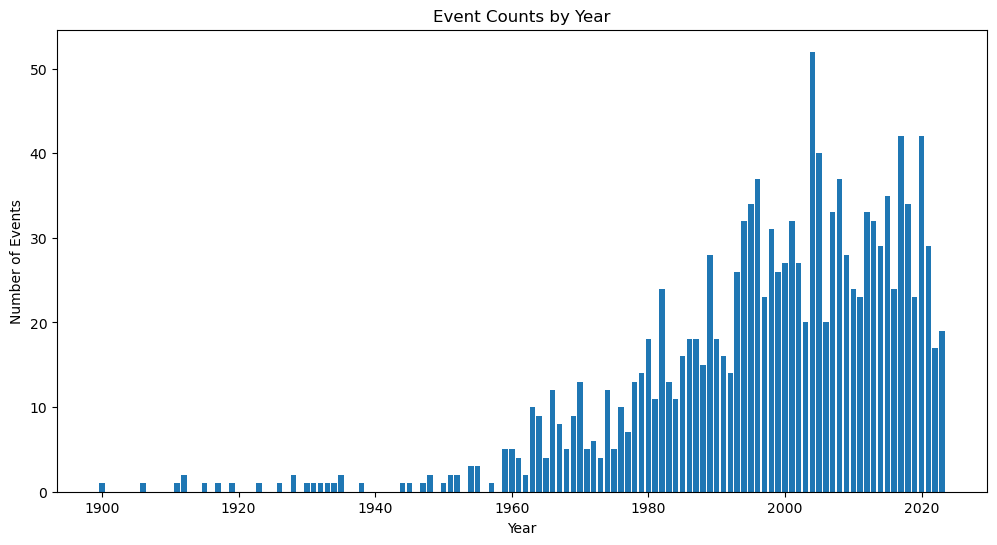

In [6]:
# Visualise event frequency
counts = emdat_subset[['Start Year', 'DisNo.']].drop_duplicates().groupby(['Start Year']).size().reset_index(name='count')

all_years = pd.DataFrame({'Start Year': range(counts['Start Year'].min(), counts['Start Year'].max() + 1)})
counts_filled = all_years.merge(counts, on='Start Year', how='left').fillna(0)
plt.figure(figsize=(12, 6))
plt.bar(counts_filled['Start Year'], counts_filled['count'])
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Event Counts by Year')

EM-DAT warns that data before the year 2000 is incomplete. Let's choose (arbitrarily) 1980 as the start of 'good' data coverage. We have to assume that the biggest events, at least, are included here.


In [7]:
year_range = (1980, 2024)
emdat_subset = emdat_subset[
    (emdat_subset['Start Year'] >= year_range[0]) &
    (emdat_subset['Start Year'] <= year_range[1])
]

n_years = year_range[1] - year_range[0] + 1

In [10]:
from copy import deepcopy

rps = deepcopy(emdat_subset)[['Start Year', 'DisNo.', 'ISO', 'region', 'Disaster Subtype', "Total Damage, Adjusted ('000 US$)"]]
rps = rps.rename(columns={
    'Start Year': 'year',
    'DisNo.': 'emdat_eventcountry_id',
    'ISO': 'country',
    'Disaster Subtype': 'type',
    "Total Damage, Adjusted ('000 US$)": 'emdat_impact_scaled'
    })
rps['emdat_impact_scaled'] = 1000 * rps['emdat_impact_scaled']
rps['event_id'] = ['-'.join(s.split('-')[:-1]) for s in rps['emdat_eventcountry_id']]
rps = rps.sort_values(['region', 'country', 'year', 'emdat_impact_scaled'], ascending=[True, True, True, False])
print(rps)
rps.to_csv(Path(output_dir, 'tc_full.csv'), index=False)

       year emdat_eventcountry_id country region              type  \
4589   1999         1999-0528-AIA     AIA    NA1  Tropical cyclone   
9873   2017         2017-0381-AIA     AIA    NA1  Tropical cyclone   
2590   1989         1989-0115-ATG     ATG    NA1  Tropical cyclone   
3701   1995         1995-0192-ATG     ATG    NA1  Tropical cyclone   
4347   1998         1998-0383-ATG     ATG    NA1  Tropical cyclone   
...     ...                   ...     ...    ...               ...   
11531  2022         2022-0680-TWN     TWN    WP4  Tropical cyclone   
11780  2023         2023-0464-TWN     TWN    WP4  Tropical cyclone   
2589   1989         1989-0115-ANT     ANT   None  Tropical cyclone   
3706   1995         1995-0193-ANT     ANT   None  Tropical cyclone   
6476   2005         2005-0662-SPI     SPI   None  Tropical cyclone   

       emdat_impact_scaled   event_id  
4589          8.800000e+04  1999-0528  
9873          2.387850e+08  2017-0381  
2590          1.888600e+08  1989-0115  

In [14]:
# calculate return period impacts by country

rp_agg = copy.deepcopy(rps)
rp_agg = rp_agg.rename(columns={'emdat_impact_scaled': 'impact'}).reset_index()
n_years = np.max(rps['year']) - np.min(rps['year']) + 1
rp_agg = rp_agg[['region', 'country', 'year', 'impact']].groupby(['region', 'country', 'year']).agg('sum')
rp_agg = rp_agg.sort_values(['region', 'country', 'impact'], ascending=[True, True, False])
rp_agg['rank'] = rp_agg.groupby(['region', 'country']).cumcount() + 1
rp_agg['rp'] = n_years / rp_agg['rank']
rp_agg = rp_agg.reset_index()[['region', 'country', 'year', 'rp', 'impact']]

print(rp_agg)
rp_agg.to_csv(Path(output_dir, 'tc_rp_country.csv'), index=False)

    region country  year         rp       impact
0      NA1     AIA  2017  44.000000  238785000.0
1      NA1     AIA  1999  22.000000      88000.0
2      NA1     ATG  1995  44.000000  672181000.0
3      NA1     ATG  2017  22.000000  298482000.0
4      NA1     ATG  1989  14.666667  188860000.0
..     ...     ...   ...        ...          ...
650    WP4     TWN  2018   2.315789   39626000.0
651    WP4     TWN  2015   2.200000   32103000.0
652    WP4     TWN  2017   2.095238   20536000.0
653    WP4     TWN  2023   2.000000   10000000.0
654    WP4     TWN  2022   1.913043     400000.0

[655 rows x 5 columns]


In [13]:
# calculate return period impacts for the region

rp_agg = copy.deepcopy(rps)
rp_agg = rp_agg.rename(columns={'emdat_impact_scaled': 'impact'}).reset_index()
n_years = np.max(rps['year']) - np.min(rps['year']) + 1
rp_agg = rp_agg[['region', 'year', 'impact']].groupby(['region', 'year']).agg('sum')
rp_agg = rp_agg.sort_values(['region', 'impact'], ascending=[True, False])
rp_agg['rank'] = np.arange(rp_agg.shape[0]) + 1
rp_agg['rp'] = n_years / rp_agg['rank']
rp_agg = rp_agg.reset_index()[['region', 'year', 'rp', 'impact']]

print(rp_agg)
rp_agg.to_csv(Path(output_dir, 'tc_rp_region.csv'), index=False)

    region  year         rp        impact
0      NA1  2017  44.000000  9.179145e+10
1      NA1  1998  22.000000  2.248855e+10
2      NA1  2005  14.666667  1.734500e+10
3      NA1  2004  11.000000  1.305920e+10
4      NA1  2023   8.800000  1.270500e+10
..     ...   ...        ...           ...
336    WP4  2010   0.130564  9.810800e+07
337    WP4  1983   0.130178  3.685800e+07
338    WP4  1980   0.129794  2.564000e+07
339    WP4  2021   0.129412  1.404000e+07
340    WP4  2023   0.129032  1.000000e+07

[341 rows x 4 columns]
